In [1]:
import pandas as pd
import torch
from torch.nn import Linear
import torch.nn.functional as F
import numpy as np
import torch_geometric
from torch_geometric.data import Data
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt
from torch_geometric.nn.norm import LayerNorm
from pathlib import Path

from torch_geometric.datasets import Planetoid, Reddit2, Flickr
from torch_geometric.transforms import NormalizeFeatures

In [2]:
# dataset = Planetoid(root='data/Planetoid', name='PubMed', transform=NormalizeFeatures())
# dataset = Reddit2(root='data/Reddit2')
dataset = Flickr(root="data/Flickr")
data = dataset[0]

In [3]:
data

Data(x=[89250, 500], edge_index=[2, 899756], y=[89250], train_mask=[89250], val_mask=[89250], test_mask=[89250])

In [4]:
data.train_mask.sum()

tensor(44625)

In [5]:
data.val_mask.sum()

tensor(22312)

In [6]:
data.test_mask.sum()

tensor(22313)

In [17]:
scaler = StandardScaler()
scaler.fit(data.x[data.train_mask])
data.x = torch.Tensor(scaler.transform(data.x))

In [18]:
rf_model = RandomForestClassifier(
    n_estimators=30,
    max_depth=100,
    random_state=1105
)

rf_model.fit(data.x[data.train_mask], data.y[data.train_mask])
y_pred = rf_model.predict(data.x[data.test_mask])
y_true = data.y[data.test_mask].numpy()

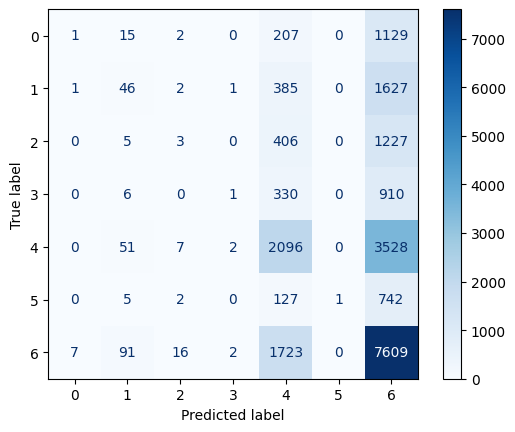

Accuracy: 0.4373
Precision: 0.3475
Recall: 0.1716
f1 score: 0.1446


In [19]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred, average='macro'):.4f}")
print(f"Recall: {recall_score(y_true, y_pred, average='macro'):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred, average='macro'):.4f}")

In [20]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(
    random_state=1105
)

lr_model.fit(data.x[data.train_mask], data.y[data.train_mask])
y_pred = lr_model.predict(data.x[data.test_mask])
y_true = data.y[data.test_mask].numpy()

c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


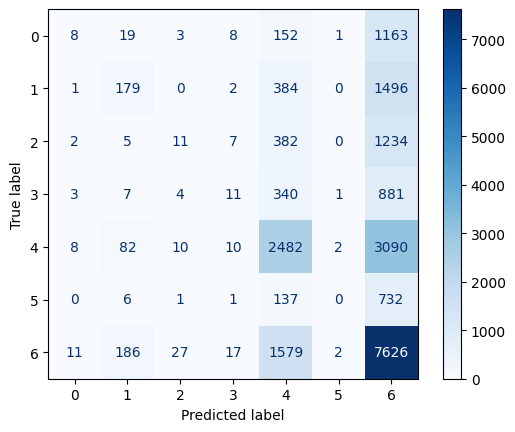

Accuracy: 0.4624
Precision: 0.2757
Recall: 0.1932
f1 score: 0.1745


In [21]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred, average='macro'):.4f}")
print(f"Recall: {recall_score(y_true, y_pred, average='macro'):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred, average='macro'):.4f}")

In [48]:
from sklearn.svm import LinearSVC

class_weight = {
    0: 1.0,
    1: 4.0
}
svc_model = LinearSVC(
    # class_weight=class_weight,
    random_state=1105
)

svc_model.fit(data.x[data.train_mask], data.y[data.train_mask])
y_pred = svc_model.predict(data.x[data.test_mask])
y_true = data.y[data.test_mask].numpy()

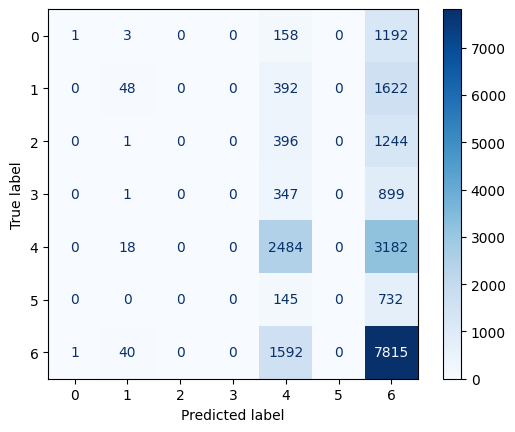

Accuracy: 0.4638
Precision: 0.2645
Recall: 0.1840
f1 score: 0.1553


c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [49]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred, average='macro'):.4f}")
print(f"Recall: {recall_score(y_true, y_pred, average='macro'):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred, average='macro'):.4f}")

In [23]:
def count_parameters(params):
    num = sum(p.numel() for p in params if p.requires_grad)
    print(f"{num:,}")
    return num

In [50]:
class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(data.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, hidden_channels * 2)
        self.lin3 = Linear(hidden_channels * 2, hidden_channels * 4)
        self.lin4 = Linear(hidden_channels * 4, hidden_channels * 8)
        self.lin5 = Linear(hidden_channels * 8, hidden_channels * 4)
        self.lin6 = Linear(hidden_channels * 4, hidden_channels * 2)
        self.lin7 = Linear(hidden_channels * 2, dataset.num_classes)
        self.norm1 = torch.nn.LayerNorm(hidden_channels)
        self.norm2 = torch.nn.LayerNorm(hidden_channels * 2)
        self.norm3 = torch.nn.LayerNorm(hidden_channels * 4)
        self.norm4 = torch.nn.LayerNorm(hidden_channels * 8)
        self.norm5 = torch.nn.LayerNorm(hidden_channels * 4)
        self.norm6 = torch.nn.LayerNorm(hidden_channels * 2)
        self.log_softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.lin1(x)
        x = self.norm1(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        x = self.norm2(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin3(x)
        x = self.norm3(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin4(x)
        x = self.norm4(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin5(x)
        x = self.norm5(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin6(x)
        x = self.norm6(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin7(x)
        # x = self.log_softmax(x)
        # x = x.squeeze()
        return x
    
model = MLP(hidden_channels=64)
print(f"MLP model number of params: {count_parameters(model.parameters()):,}")

372,807
MLP model number of params: 372,807


In [51]:
weight = torch.Tensor([1.0, 2.5])
# criterion = torch.nn.NLLLoss(weight=weight)  # Define loss criterion.
# criterion = torch.nn.BCEWithLogitsLoss()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)  # Define optimizer.

losses = []
v_losses = []
best_v_loss = 100000
COUNT = 50
val_early_stop_count = COUNT
val_early_stop_continuous_flag = False

for epoch in range(1, 2001):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    X_tmp = data.x[data.train_mask]
    y_tmp = data.y[data.train_mask]
    preds = model(X_tmp)  # Perform a single forward pass.
    loss = criterion(preds, y_tmp)  # Compute the loss solely based on the training nodes.
    losses.append(loss.item())
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    
    model.eval()
    with torch.no_grad():
        v_X_tmp = data.x[data.val_mask]
        v_y_tmp = data.y[data.val_mask]
        v_preds = model(v_X_tmp)
        v_loss = criterion(v_preds, v_y_tmp)
        v_losses.append(v_loss.item())
    print(f'Epoch: {epoch:03d}, Train_loss: {loss:.4f} / Val_loss: {v_loss:.4f}')
    
    if v_loss.item() < best_v_loss:
        best_v_loss = v_loss.item()
        val_early_stop_continuous_flag = False
        val_early_stop_count = COUNT
    else:
        val_early_stop_continuous_flag = True
        val_early_stop_count -= 1
        if val_early_stop_count == 0:
            print(f"============== Early stopped at Epoch: {epoch}")
            break

Epoch: 001, Train_loss: 2.0243 / Val_loss: 1.6280
Epoch: 002, Train_loss: 1.7900 / Val_loss: 1.6677
Epoch: 003, Train_loss: 1.6957 / Val_loss: 1.6985
Epoch: 004, Train_loss: 1.6753 / Val_loss: 1.6923
Epoch: 005, Train_loss: 1.6784 / Val_loss: 1.6705
Epoch: 006, Train_loss: 1.6697 / Val_loss: 1.6472
Epoch: 007, Train_loss: 1.6651 / Val_loss: 1.6281
Epoch: 008, Train_loss: 1.6584 / Val_loss: 1.6141
Epoch: 009, Train_loss: 1.6523 / Val_loss: 1.6034
Epoch: 010, Train_loss: 1.6499 / Val_loss: 1.5952
Epoch: 011, Train_loss: 1.6444 / Val_loss: 1.5897
Epoch: 012, Train_loss: 1.6416 / Val_loss: 1.5866
Epoch: 013, Train_loss: 1.6375 / Val_loss: 1.5848
Epoch: 014, Train_loss: 1.6362 / Val_loss: 1.5832
Epoch: 015, Train_loss: 1.6363 / Val_loss: 1.5814
Epoch: 016, Train_loss: 1.6319 / Val_loss: 1.5792
Epoch: 017, Train_loss: 1.6328 / Val_loss: 1.5771
Epoch: 018, Train_loss: 1.6288 / Val_loss: 1.5753
Epoch: 019, Train_loss: 1.6223 / Val_loss: 1.5741
Epoch: 020, Train_loss: 1.6250 / Val_loss: 1.5734


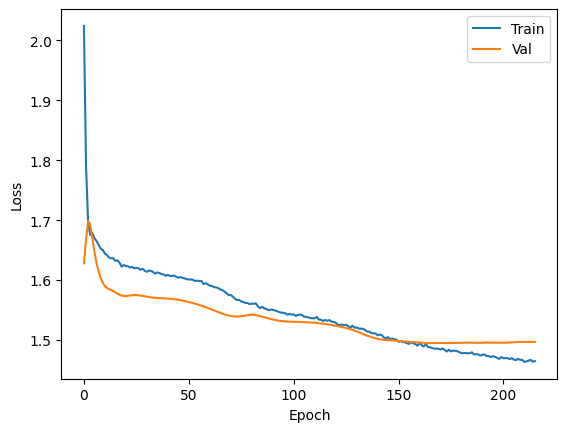

In [52]:
plt.plot(losses)
plt.plot(v_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Val"])
plt.show()

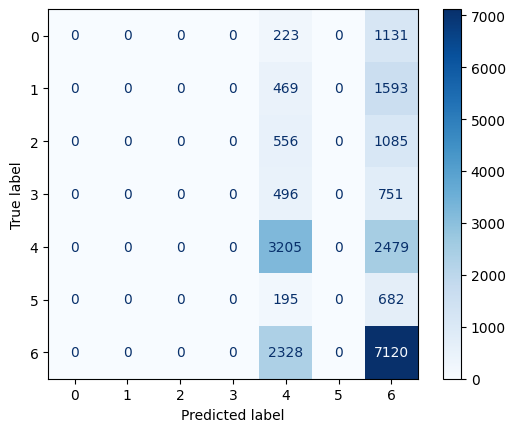

Accuracy: 0.4638
Precision: 0.2645
Recall: 0.1840
f1 score: 0.1553


c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [53]:
model.eval()
X_tmp_test = data.x[data.test_mask]
y_tmp_test = data.y[data.test_mask]
with torch.no_grad():
    out = model(X_tmp_test)
pred = out.argmax(dim=1)  # Use the class with highest probability.

cm = confusion_matrix(y_tmp_test, pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred, average='macro'):.4f}")
print(f"Recall: {recall_score(y_true, y_pred, average='macro'):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred, average='macro'):.4f}")

In [54]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(data.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels * 2)
        self.conv3 = GCNConv(hidden_channels * 2, hidden_channels * 4)
        self.conv4 = GCNConv(hidden_channels * 4, hidden_channels * 8)
        self.conv5 = GCNConv(hidden_channels * 8, hidden_channels * 4)
        self.conv6 = GCNConv(hidden_channels * 4, hidden_channels * 2)
        self.conv7 = GCNConv(hidden_channels * 2, dataset.num_classes)
        self.norm1 = LayerNorm(hidden_channels)
        self.norm2 = LayerNorm(hidden_channels * 2)
        self.norm3 = LayerNorm(hidden_channels * 4)
        self.norm4 = LayerNorm(hidden_channels * 8)
        self.norm5 = LayerNorm(hidden_channels * 4)
        self.norm6 = LayerNorm(hidden_channels * 2)
        self.log_softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.norm1(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.norm2(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        x = self.norm3(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv4(x, edge_index)
        x = self.norm4(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv5(x, edge_index)
        x = self.norm5(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv6(x, edge_index)
        x = self.norm6(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv7(x, edge_index)
        # x = x.squeeze()
        # x = self.log_softmax(x)
        return x

model = GCN(hidden_channels=64)
print(f"GCN model number of params: {count_parameters(model.parameters()):,}")

372,807
GCN model number of params: 372,807


In [55]:
weight = torch.Tensor([1.0, 2.5])
# criterion = torch.nn.NLLLoss(weight=weight)  # Define loss criterion.
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)  # Define optimizer.

losses = []
v_losses = []
best_v_loss = 100000
COUNT = 100
val_early_stop_count = COUNT
val_early_stop_continuous_flag = False

for epoch in range(1, 2001):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    outs = model(data.x, data.edge_index)  # Perform a single forward pass.
    preds = outs[data.train_mask]
    loss = criterion(preds, data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    losses.append(loss.item())
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    
    model.eval()
    with torch.no_grad():
        v_preds = outs[data.val_mask]
        v_loss = criterion(v_preds, data.y[data.val_mask])
        v_losses.append(v_loss.item())
    print(f'Epoch: {epoch:03d}, Train_loss: {loss:.4f} / Val_loss: {v_loss:.4f}')
    
    if v_loss.item() < best_v_loss:
        best_v_loss = v_loss.item()
        val_early_stop_continuous_flag = False
        val_early_stop_count = COUNT
    else:
        val_early_stop_continuous_flag = True
        val_early_stop_count -= 1
        if val_early_stop_count == 0:
            print(f"============== Early stopped at Epoch: {epoch}")
            break

Epoch: 001, Train_loss: 1.9558 / Val_loss: 1.9534
Epoch: 002, Train_loss: 1.7815 / Val_loss: 1.7800
Epoch: 003, Train_loss: 1.7127 / Val_loss: 1.7133
Epoch: 004, Train_loss: 1.7208 / Val_loss: 1.7148
Epoch: 005, Train_loss: 1.7007 / Val_loss: 1.6987
Epoch: 006, Train_loss: 1.6843 / Val_loss: 1.6864
Epoch: 007, Train_loss: 1.6653 / Val_loss: 1.6677
Epoch: 008, Train_loss: 1.6636 / Val_loss: 1.6664
Epoch: 009, Train_loss: 1.6674 / Val_loss: 1.6663
Epoch: 010, Train_loss: 1.6811 / Val_loss: 1.6802
Epoch: 011, Train_loss: 1.6796 / Val_loss: 1.6813
Epoch: 012, Train_loss: 1.6712 / Val_loss: 1.6720
Epoch: 013, Train_loss: 1.6604 / Val_loss: 1.6602
Epoch: 014, Train_loss: 1.6576 / Val_loss: 1.6556
Epoch: 015, Train_loss: 1.6523 / Val_loss: 1.6523
Epoch: 016, Train_loss: 1.6526 / Val_loss: 1.6510
Epoch: 017, Train_loss: 1.6505 / Val_loss: 1.6475
Epoch: 018, Train_loss: 1.6380 / Val_loss: 1.6399
Epoch: 019, Train_loss: 1.6369 / Val_loss: 1.6397
Epoch: 020, Train_loss: 1.6329 / Val_loss: 1.6302


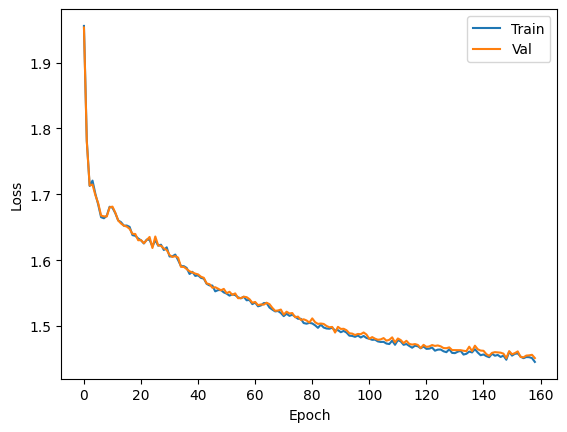

In [40]:
plt.plot(losses)
plt.plot(v_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Val"])
plt.show()

In [41]:
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
pred = out.argmax(dim=1)  # Use the class with highest probability.

y_pred = pred[data.test_mask].numpy()
y_true = data.y[data.test_mask].numpy()

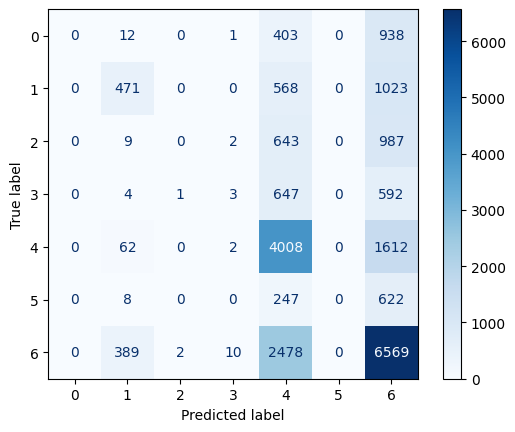

Accuracy: 0.4953
Precision: 0.2340
Recall: 0.2330
f1 score: 0.2094


c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [42]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred, average='macro'):.4f}")
print(f"Recall: {recall_score(y_true, y_pred, average='macro'):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred, average='macro'):.4f}")

In [43]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(data.num_features, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels * 2)
        self.conv3 = GATConv(hidden_channels * 2, hidden_channels * 4)
        self.conv4 = GATConv(hidden_channels * 4, hidden_channels * 8)
        self.conv5 = GATConv(hidden_channels * 8, hidden_channels * 4)
        self.conv6 = GATConv(hidden_channels * 4, hidden_channels * 2)
        self.conv7 = GATConv(hidden_channels * 2, dataset.num_classes)
        self.norm1 = LayerNorm(hidden_channels)
        self.norm2 = LayerNorm(hidden_channels * 2)
        self.norm3 = LayerNorm(hidden_channels * 4)
        self.norm4 = LayerNorm(hidden_channels * 8)
        self.norm5 = LayerNorm(hidden_channels * 4)
        self.norm6 = LayerNorm(hidden_channels * 2)
        self.log_softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.norm1(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.norm2(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        x = self.norm3(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv4(x, edge_index)
        x = self.norm4(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv5(x, edge_index)
        x = self.norm5(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv6(x, edge_index)
        x = self.norm6(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv7(x, edge_index)
        # x = self.log_softmax(x)
        # x = x.squeeze()
        return x


model = GAT(hidden_channels=64)
print(f"GAT model number of params: {count_parameters(model.parameters()):,}")

375,509
GAT model number of params: 375,509


In [44]:
weight = torch.Tensor([1.0, 2.5])
# criterion = torch.nn.NLLLoss(weight=weight) # Define loss criterion.
# criterion = torch.nn.BCEWithLogitsLoss()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)  # Define optimizer.

losses = []
v_losses = []
best_v_loss = 100000
COUNT = 10
val_early_stop_count = COUNT
val_early_stop_continuous_flag = False

for epoch in range(1, 2001):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    outs = model(data.x, data.edge_index)  # Perform a single forward pass.
    preds = outs[data.train_mask]
    loss = criterion(preds, data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    losses.append(loss.item())
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    
    model.eval()
    with torch.no_grad():
        v_preds = outs[data.val_mask]
        v_loss = criterion(v_preds, data.y[data.val_mask])
        v_losses.append(v_loss.item())
    print(f'Epoch: {epoch:03d}, Train_loss: {loss:.4f} / Val_loss: {v_loss:.4f}')
    
    if v_loss.item() < best_v_loss:
        best_v_loss = v_loss.item()
        val_early_stop_continuous_flag = False
        val_early_stop_count = COUNT
    else:
        val_early_stop_continuous_flag = True
        val_early_stop_count -= 1
        if val_early_stop_count == 0:
            print(f"============== Early stopped at Epoch: {epoch}")
            break

Epoch: 001, Train_loss: 2.7335 / Val_loss: 2.7194
Epoch: 002, Train_loss: 2.5222 / Val_loss: 2.5118
Epoch: 003, Train_loss: 2.6644 / Val_loss: 2.6759
Epoch: 004, Train_loss: 2.4366 / Val_loss: 2.4185
Epoch: 005, Train_loss: 2.1259 / Val_loss: 2.1255
Epoch: 006, Train_loss: 2.1554 / Val_loss: 2.1439
Epoch: 007, Train_loss: 2.2195 / Val_loss: 2.2069
Epoch: 008, Train_loss: 2.1068 / Val_loss: 2.1096
Epoch: 009, Train_loss: 2.0346 / Val_loss: 2.0327
Epoch: 010, Train_loss: 2.0245 / Val_loss: 2.0281
Epoch: 011, Train_loss: 1.9137 / Val_loss: 1.9117
Epoch: 012, Train_loss: 2.0418 / Val_loss: 2.0333
Epoch: 013, Train_loss: 1.8631 / Val_loss: 1.8605
Epoch: 014, Train_loss: 1.9159 / Val_loss: 1.9080
Epoch: 015, Train_loss: 1.8528 / Val_loss: 1.8478
Epoch: 016, Train_loss: 1.9565 / Val_loss: 1.9589
Epoch: 017, Train_loss: 2.0312 / Val_loss: 2.0183
Epoch: 018, Train_loss: 1.8968 / Val_loss: 1.8943
Epoch: 019, Train_loss: 1.8309 / Val_loss: 1.8300
Epoch: 020, Train_loss: 1.7715 / Val_loss: 1.7644


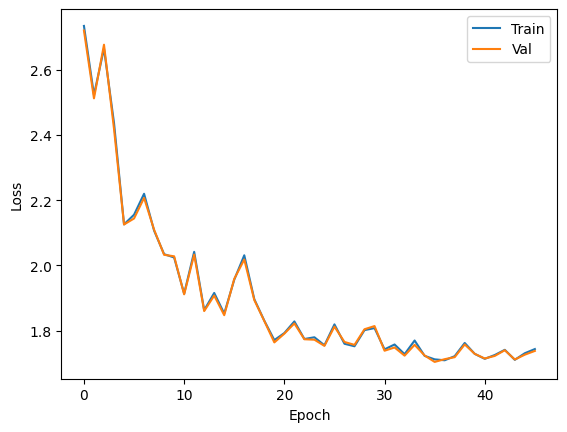

In [45]:
plt.plot(losses)
plt.plot(v_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Val"])
plt.show()

In [46]:
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
# pred = F.sigmoid(out).round()
pred = out.argmax(dim=1)  # Use the class with highest probability.

y_pred = pred[data.test_mask].numpy()
y_true = data.y[data.test_mask].numpy()

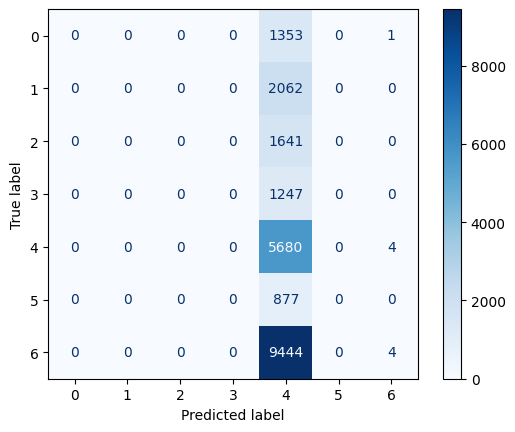

Accuracy: 0.2547
Precision: 0.0999
Recall: 0.1428
f1 score: 0.0581


c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [47]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred, average='macro'):.4f}")
print(f"Recall: {recall_score(y_true, y_pred, average='macro'):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred, average='macro'):.4f}")